In [1]:
import os
import re
import keras
import urllib
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline
sns.set_style('white')
plt.style.use('bmh')

Using TensorFlow backend.


## Downloading images, converting them to numpy arrays

In [2]:
df = pd.read_json('data/themoviedb-sample-4-17-2017.json')
df = df[df['poster_path'].isnull() == False]
df['poster_url'] = df['poster_path'].apply(lambda x: 'http://image.tmdb.org/t/p/w92{}'.format(x))
df = df[['title', 'genre', 'poster_url']]
print(df.shape)
df.head()

(9175, 3)


,title,genre,poster_url
0,Bought,Documentary,http://image.tmdb.org/t/p/w92/5q3CQLHMbvsjxK4V...
1,Egypt Underworld,Documentary,http://image.tmdb.org/t/p/w92/vHZf7KA7RGMxWl2r...
2,Chinese Heroes,Action,http://image.tmdb.org/t/p/w92/74F1NxjpQFoXoJzG...
3,Shakedown,Action,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...
4,Shakedown,Drama,http://image.tmdb.org/t/p/w92/eILw7xfKn99cPU6n...


#### Downloading all the posters
Here, we download them at the smallest size (width = 92 pixels). 

In [3]:
for url in df['poster_url'].unique():
    file_name = re.findall(r'(?<=w92\/)(.*)', url)[0]
    if file_name not in os.listdir('data/img'):
        urllib.urlretrieve(url, 'data/img/{}'.format(file_name))

#### Flattening into numpy arrays
Resizing images to `(138, 92, 3)`. I expect this will lose us some precision later.

In [4]:
images = []
y = []

for image_file in os.listdir('data/img'):
    img = load_img('data/img/{}'.format(image_file))
    images.append(np.resize(img_to_array(img),(138,92,3)))
    y.append(np.array([x for x in df[df['poster_url'] == 'http://image.tmdb.org/t/p/w92/{}'.format(image_file)]['genre'].values]))


In [5]:
y[0:5]

[array([u'Drama', u'Horror'], 
       dtype='<U6'), array([u'Documentary'], 
       dtype='<U11'), array([u'Drama', u'Romance'], 
       dtype='<U7'), array([u'Adventure', u'Comedy'], 
       dtype='<U9'), array([u'Comedy', u'Family', u'Fantasy', u'Science Fiction'], 
       dtype='<U15')]

In [6]:
X = np.array(images)
# Normalizing away from 255
X = X / 255.
input_shape = X.shape
print(input_shape)

(4722, 138, 92, 3)


In [7]:
all_genres = pd.DataFrame(index = range(0,4722))

for row in y:
    for genre in row:
        if genre in all_genres:
            pass
        else:
            all_genres[genre] = 0

for index, row in enumerate(y):
    for genre in row:
        all_genres[genre].loc[index] = 1
        
print(all_genres.shape)
all_genres.head()

(4722, 20)


,Drama,Horror,Documentary,Romance,Adventure,Comedy,Family,Fantasy,Science Fiction,Foreign,Action,Crime,Music,Thriller,TV Movie,History,Mystery,Animation,War,Western
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
Y = np.array(all_genres)
print(Y.shape)

(4722, 20)


#### Fitting a simple CNN model

In [52]:
# Super simple CNN
model = Sequential()

# Input layer
model.add(Conv2D(80, activation='relu', 
                 kernel_size=(2, 2),
                 data_format = 'channels_last',
                 input_shape=(138,92,3)))

# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# # --- next layer ---
# model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# # --- max pool ---
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # # --- next layer ---
# model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
# # # --- max pool ---
# model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
# --- classification ---
model.add(Dense(20, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 137, 91, 80)       1040      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 68, 45, 80)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 66, 43, 100)       72100     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 33, 21, 100)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 69300)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4435264   
_________________________________________________________________
dense_12 (Dense)             (None, 20)                1300      
Total para

In [53]:
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [54]:
batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

history = model.fit(X, Y,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    epochs = 5,
                    callbacks = [early_stopping_monitor],
                    verbose=1)


Train on 3777 samples, validate on 945 samples
Epoch 1/5
3777/3777 [==============================] - 14s - loss: 0.2979 - acc: 0.9002 - val_loss: 0.2944 - val_acc: 0.9038

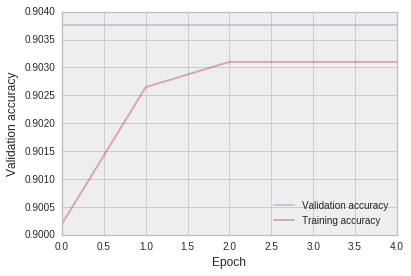

In [56]:
plt.plot(history.history['val_acc'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(history.history['acc'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
# plt.ylim([0,1])
plt.legend(loc = 'best')
plt.show()